# Curso de CNN con PyTorch

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

## 1) 🎯 Capas Convolucionales


Las **capas convolucionales** son el corazón de las CNN (Redes Neuronales Convolucionales).

Permiten extraer **características espaciales** como bordes, texturas o patrones complejos directamente desde las imágenes de entrada.

## 2) 📐 Fundamento Matemático

### 2.1) 🔢 ¿Qué es una convolución?

Una **convolución** es una operación matemática que aplica un **filtro (o kernel)** sobre una imagen para producir un mapa de características.

**Fórmula:**
$$
O(i, j) = \sum_{m=0}^{kH-1} \sum_{n=0}^{kW-1} I(i+m, j+n) \cdot K(m,n)
$$

Donde:
- \( I \): Imagen de entrada  
- \( K \): Kernel o filtro  
- \( O \): Salida (feature map)  
- \( kH, kW \): Altura y ancho del filtro  

---
### 2.2) 🧰 Componentes importantes

**Filtros (Kernels)**
- Son pequeños tensores (e.g. 3×3, 5×5) entrenables.
- Detectan patrones específicos como bordes, líneas o texturas.

**Stride**
- Determina cuánto se desplaza el filtro al aplicarse.
- `stride=1` → máxima superposición  
- `stride=2` → reduce resolución más rápido

**Padding**
- Añade bordes de ceros para no perder información en los bordes.
- `same` padding → salida del mismo tamaño que la entrada  
- `valid` padding → sin relleno

**Canales**
- Imágenes RGB tienen 3 canales.
- Cada filtro se aplica en **todos los canales**, y se suman.



---

### 2.3) 🔍 ¿Para qué sirven?



- Extraer patrones espaciales
- Detectar jerarquías (de píxeles a bordes, de bordes a objetos)
- Reducir dimensionalidad con stride o pooling


## 3) 🧪 Ejemplos

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
### 📷 Imagen 1: Gradiente blanco y negro

# Imagen sintética: gradiente horizontal
gradient = np.tile(np.linspace(0, 1, 64), (64, 1))
img_grad = torch.tensor(gradient, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

### 📷 Imagen 2: Letra "P"

P_img = np.zeros((64, 64))
## Parte vertical
P_img[10:50, 10:20] = 1
## Parte superior del círculo de la P
P_img[10:20, 10:40] = 1
## Parte media horizontal de la P
P_img[30:40, 10:40] = 1
## Borde derecho del "círculo"
P_img[20:30, 30:40] = 1
## Parte interior para que no parezca una B
P_img[20:30, 20:30] = 0  # vaciar la parte interior
img_P = torch.tensor(P_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

### 📷 Imagen 3: RGB cargada por el usuario

# Carga y preprocesamiento
img_path = "/content/logo_platzi.jpg"
img_rgb = Image.open(img_path).resize((64, 64))
transform = transforms.Compose([
    transforms.ToTensor()
])
img_rgb_tensor = transform(img_rgb).unsqueeze(0).to(device)  # (1, 3, 64, 64)

### 🧪 3.1) Aplicar un filtro de detección de bordes

In [4]:
# Filtro Sobel vertical
sobel_y = torch.tensor([[-1., -2., -1.],
                        [ 0.,  0.,  0.],
                        [ 1.,  2.,  1.]])

kernel = sobel_y.unsqueeze(0).unsqueeze(0).to(device)  # ➜ shape: (1, 1, 3, 3)

In [5]:
def apply_convolution(img):
    return F.conv2d(img, kernel, padding=1)

In [6]:
# Visualizar
def visualize_conv(img, title):
    out = apply_convolution(img)
    out_np = out.squeeze().detach().cpu().numpy()
    img_np = img.squeeze().detach().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(out_np, cmap='gray')
    plt.title("Filtro Sobel")
    plt.axis("off")
    plt.suptitle(title)
    plt.show()

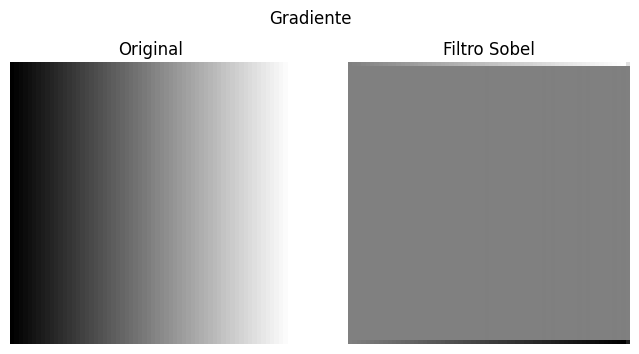

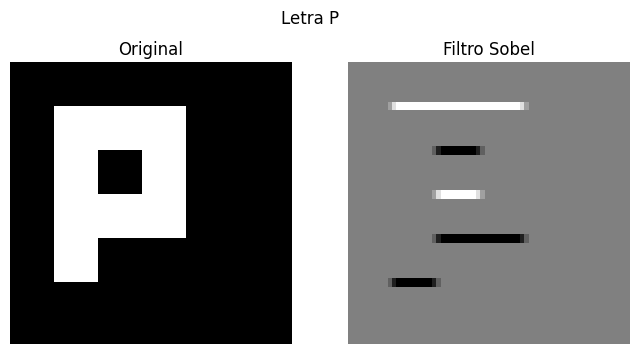

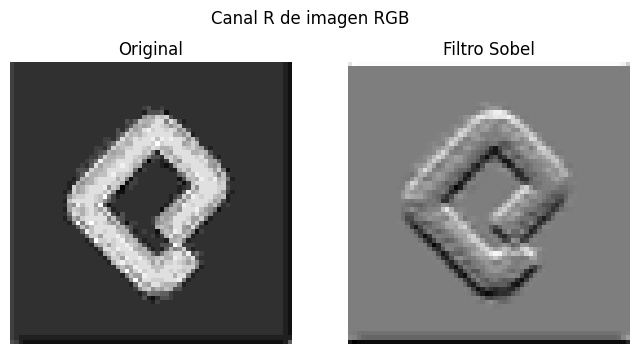

In [7]:
visualize_conv(img_grad, "Gradiente")
visualize_conv(img_P, "Letra P")
visualize_conv(img_rgb_tensor[:, 0:1, :, :], "Canal R de imagen RGB")

### 🧪 3.2) Efecto del **stride** y **padding**


In [8]:
def conv_stride(img, stride, padding):
    return F.conv2d(img, kernel, stride=stride, padding=padding)

def show_stride_effect(img, params, title):
    """
    Visualiza los efectos de diferentes combinaciones de stride y padding.

    Parámetros:
    - img: Imagen de entrada (tensor).
    - params: Lista de tuplas (stride, padding).
    - title: Título general de la figura.
    """
    results = [conv_stride(img, stride=s, padding=p) for s, p in params]

    plt.figure(figsize=(5 * len(params), 4))
    for i, ((s, p), res) in enumerate(zip(params, results)):
        plt.subplot(1, len(params), i + 1)
        plt.imshow(res.squeeze().detach().cpu().numpy(), cmap='gray')
        plt.title(f"stride={s}, padding={p}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

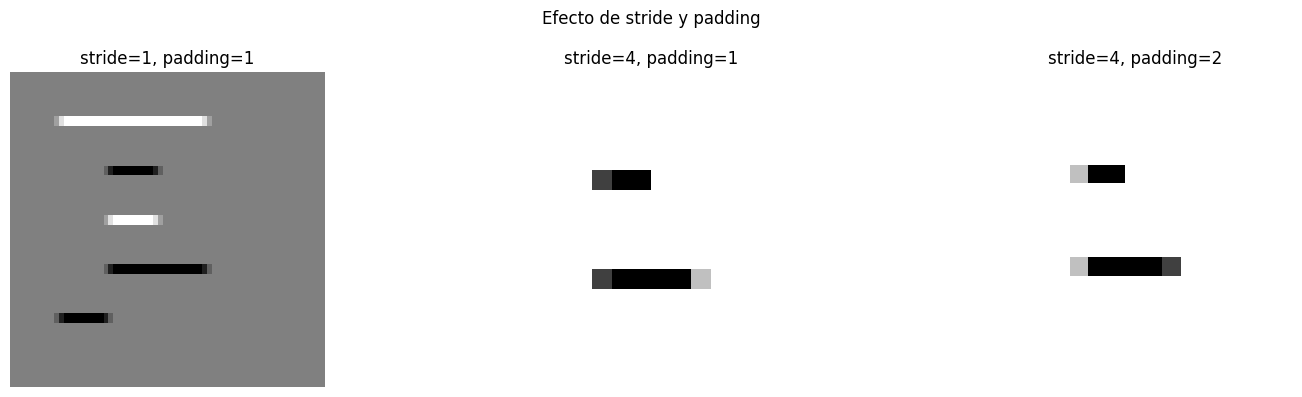

In [10]:
params = [(1, 1), (4, 1), (4, 2)]
show_stride_effect(img_P, params, "Efecto de stride y padding")

### 🧪 3.3) Canales y filtros múltiples

In [11]:
# Usamos 2 filtros distintos para ver efectos
sobel_y = torch.tensor([[-1., -2., -1.],
                        [ 0.,  0.,  0.],
                        [ 1.,  2.,  1.]])  # Filtro Sobel vertical

sobel_x = torch.tensor([[-1.,  0.,  1.],
                        [-2.,  0.,  2.],
                        [-1.,  0.,  1.]])  # Filtro Sobel horizontal

In [12]:
# Apilamos ambos filtros
kernels = torch.stack([sobel_y, sobel_x]).unsqueeze(1).to(device)  # Shape: (2, 1, 3, 3)

In [13]:
# Función para aplicar la convolución con múltiples filtros
def apply_convolution(img):
    return F.conv2d(img, kernels, padding=1)

In [14]:
# Visualizar los resultados
def visualize_conv(img, title):
    out = apply_convolution(img)
    out_np = out.squeeze().detach().cpu().numpy()  # Convertir la salida a numpy
    img_np = img.squeeze().detach().cpu().numpy()  # Convertir la imagen original a numpy

    plt.figure(figsize=(10, 5))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Imagen con filtro Sobel vertical
    plt.subplot(1, 3, 2)
    plt.imshow(out_np[0], cmap='gray')
    plt.title("Filtro Sobel Vertical")
    plt.axis("off")

    # Imagen con filtro Sobel horizontal
    plt.subplot(1, 3, 3)
    plt.imshow(out_np[1], cmap='gray')
    plt.title("Filtro Sobel Horizontal")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

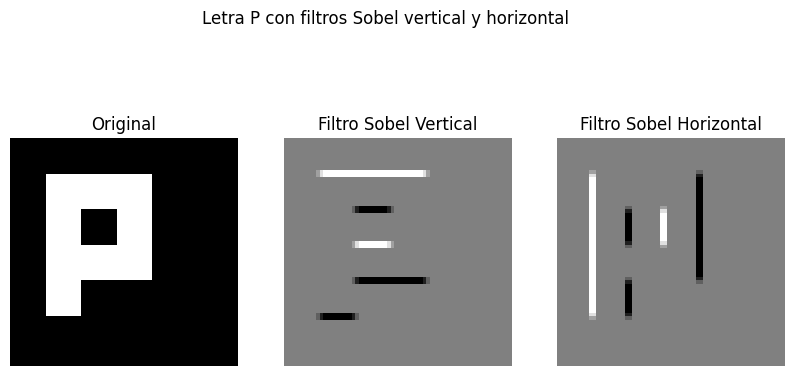

In [15]:
visualize_conv(img_P, "Letra P con filtros Sobel vertical y horizontal")

## 4) 💡 Tips

| Tema | Recomendaciones |
|------|------------------|
| Filtros | Diseñados para extraer características específicas. Los primeros detectan bordes; los últimos detectan partes de objetos. |
| Stride > 1 | Útil para reducir tamaño espacial y acelerar procesamiento. Pero se puede perder información fina. |
| Padding | Siempre usar `padding=1` si querés conservar la dimensión. Muy importante para no achicar imágenes rápidamente. |
| Canales | En RGB, cada filtro procesa todos los canales y produce 1 mapa de salida. Convierte 3 canales a N mapas. |
